# Questão prática: Desenvolver um modelo de previsão de valores de venda para casas em Ames, Iowa

fonte: [Kaggle](https://www.kaggle.com/competitions/home-data-for-ml-course/overview/evaluation)

**Objetivo**: Desenvolver um modelo que será validado "_on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price._", segundo consta no site. 

> Imports

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

> Read the csvs of training and testing data

In [101]:
df_train = pd.read_csv('home-data-for-ml-course/train.csv')
df_test = pd.read_csv('home-data-for-ml-course/test.csv')

### Data processing and data cleaning

In [102]:
# Get the log of the SalePrice
df_train['LogSalePrice'] = np.log(df_train['SalePrice'])

# In the case of missing values in the dataset, 
# we can fill them with the average value of the column in case it's numerical 
# or with the most frequent value in case it's categorical.
for column in df_train.columns:
  if df_train[column].dtype == 'object':
    # returns the most frequent value in the column, if there are multiple values with the same frequency, it returns the first one
    most_frequent_value = df_train[column].mode()[0]
    df_train.fillna({column: most_frequent_value}, inplace=True)
    df_test.fillna({column: most_frequent_value}, inplace=True)
  else:
    # returns the average value of the column
    mean_value = df_train[column].mean()
    df_train.fillna({column: mean_value}, inplace=True)
    df_test.fillna({column: mean_value}, inplace=True)

> Check if there are still null values

In [103]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

> Remember, models work better with numerical data, so we need to convert the categorical data into numerical data.


In [104]:
label_encoder = LabelEncoder()

# Encode the categorical columns
for column in df_train.columns:
  if df_train[column].dtype == 'object':
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.fit_transform(df_test[column])

> Create/transform columns for more valuable and precise predictions
<br>
For this case, I'll be summing the total squarefoot of the houses and log transforming the area to a less skewed value, the same way I did with the SalesPrice (it works better with models).
Also, we have the year the house was built and the year it was sold, so we can analyse the value of the house by it's age as well, (yS-yB).
For the other columns, I'll leave as it is now.
If the tests show some underfitting poor performances I might add or transform some other values. (I'll add edits to this very comment if so)

In [105]:
df_train['TotalSF'] = df_train['1stFlrSF'] + df_train['2ndFlrSF'] + df_train['TotalBsmtSF']
df_train['Age'] = df_train['YrSold'] - df_train['YearBuilt']
df_train['LogLotArea'] = np.log1p(df_train['LotArea'])

df_test['TotalSF'] = df_test['1stFlrSF'] + df_test['2ndFlrSF'] + df_test['TotalBsmtSF']
df_test['Age'] = df_test['YrSold'] - df_test['YearBuilt']
df_test['LogLotArea'] = np.log1p(df_test['LotArea'])


### Splitting Data

> Drop columns not useful for predictions, for that case, the ID.

> First, let us define our inputs (features) and our outputs (target).

In [106]:
df_train.drop(columns=['Id'], inplace=True)
df_test.drop(columns=['Id'], inplace=True)

# Since I took the log of the SalePrice, I will drop the original SalePrice column
df_train.drop(columns=['SalePrice'], inplace=True)

y = df_train['LogSalePrice']

# Drop LogSalePrice from the training data
aux = df_train.drop(columns=['LogSalePrice'], inplace=True)

# Align the columns of the two datasets to match one another
df_train, df_test = df_train.align(df_test, join='left', axis=1)

X = df_train

> In order to prevent from overfitting, we'll divide the train data into two subsets, one for the actual training and another one for validation, as a "pre-test".

In [107]:
# test size of 20% is a default, and random_state is set to 42 to ensure reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### Visualizing the data into charts

I have been using matplot on work for some data analysis I've been doing and it's been really fun to work with.<br>
So I'll bring it to this and also try seaborn as well.

> We'll plot the data into a chart to visualize the values, ensuring their similarities

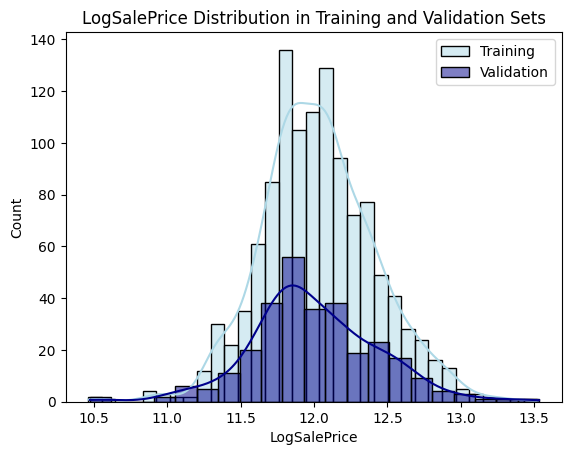

In [108]:
sns.histplot(y_train, kde=True, color='lightblue', label='Training', )
sns.histplot(y_val, kde=True, color='darkblue', label='Validation')
plt.legend()
plt.title("LogSalePrice Distribution in Training and Validation Sets")
plt.show()

The slope of the chart is simillar but not identical, which is great, it'll help fine tunning our model before actually throwing it at the test dataFrame.

### Training a XGBoost model

> Instead of normal pandas DataFrames, XGBoost uses what's called a DMatrix, mainly for improved efficient and speed

In [109]:
# Convert datasets to DMatrix
d_train = xgb.DMatrix(X_train, label=y_train)
d_val = xgb.DMatrix(X_val, label=y_val)

> Also, we can set the hyperparameters for our model. Notice the values might need to be adjusted. If I ever need it, I'll keep its track down here

The objective is to make a regression which metric should be Root-Mean-Squared-Error, hence a regression with squarederror.

In [110]:
params = {
  'objective': 'reg:squarederror', 
  'eval_metric': 'rmse',          
  'learning_rate': 0.05,           
  'max_depth': 6,                  
  'subsample': 0.8,               
  'colsample_bytree': 0.8,         
  'seed': 42                    
}

> All values settled, it's time to actually train the model

In [111]:
evals = [(d_train, 'train'), (d_val, 'eval')]
xgb_model = xgb.train(
    params,
    d_train,
    num_boost_round=1000,  # equals n_estimators in the GridSearchCV 
    evals=evals,
    early_stopping_rounds=50, 
    verbose_eval=100
)

[0]	train-rmse:0.37427	eval-rmse:0.41660
[100]	train-rmse:0.04612	eval-rmse:0.14162
[190]	train-rmse:0.02810	eval-rmse:0.14075


> Model trained, now let's validate it against our test partition

In [112]:
y_val_pred = xgb_model.predict(d_val)

# Calculate RMSE (closer to 0 is better)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE (log scale): {rmse}")

# Convert RMSE back to original scale (error seen as in prices as percentage)
original_rmse = np.exp(rmse) - 1
print(f"Approximate Error in SalePrice: ±{original_rmse:.2f}")

Validation RMSE (log scale): 0.14074523230016092
Approximate Error in SalePrice: ±0.15


> One cool thing about XGBoost is that it actually allows you to see which features were most relevant to the predictions, another reason I opted for this model.

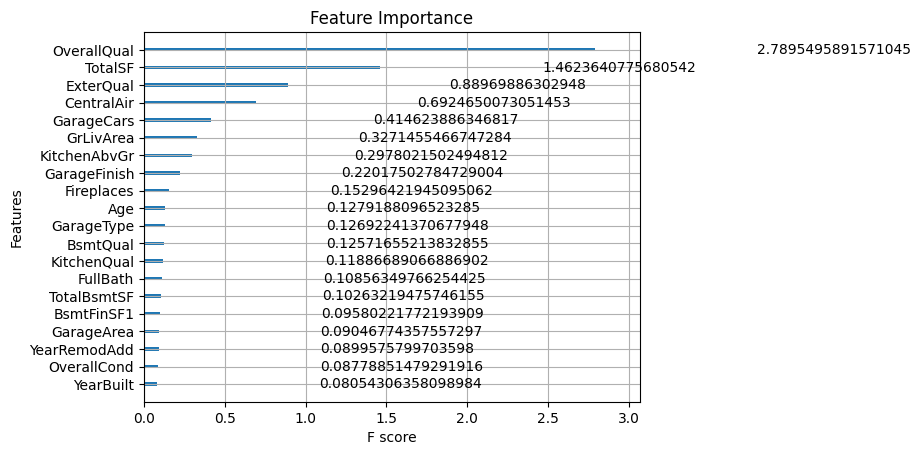

In [113]:
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain', title="Feature Importance")
plt.show()

Of the values we manipulated, it's interesting to see that the Total squared feet places as the second most importante feature, Age is somewhat up there and the log of area is nowhere to be seem.

#### Tunning the hyperparameters

There are some libs we can use to test with different sets of params to fine tune the params of our model. For this case I'll be using GridSearch and testing 3 different sets of params. It'll try different combinations between those values and retrieve the combination that leads to the best results<br>
(I changed the params by hand twice before googling up for this solution, would have saved quite the time)
<br><br>
This step took me around 10m to finish. Take it into consideration before running!

In [121]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 500, 1000]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best parameters
print("And the oscar of best parameters goes to...", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
And the oscar of best parameters goes to... {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1.0}


Now, we just adjust the params with the values found by GridSearch into our model and Rerun the training set.

In [114]:
params = {
  'objective': 'reg:squarederror', 
  'eval_metric': 'rmse',
  'colsample_bytree': 0.6,
  'learning_rate': 0.05, 
  'max_depth': 3, 
  'subsample': 1.0,        
  'seed': 42                    
}

In [115]:
evals = [(d_train, 'train'), (d_val, 'eval')]
xgb_model = xgb.train(
    params,
    d_train,
    num_boost_round=1000,  # equals n_estimators in the GridSearchCV 
    evals=evals,
    early_stopping_rounds=50, 
    verbose_eval=100
)

[0]	train-rmse:0.37610	eval-rmse:0.41771
[100]	train-rmse:0.09991	eval-rmse:0.14323
[200]	train-rmse:0.07880	eval-rmse:0.13455
[300]	train-rmse:0.06897	eval-rmse:0.13227
[339]	train-rmse:0.06617	eval-rmse:0.13248


In [116]:
y_val_pred = xgb_model.predict(d_val)

# Calculate RMSE (closer to 0 is better)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE (log scale): {rmse}")

# Convert RMSE back to original scale (error seen as in prices as percentage)
original_rmse = np.exp(rmse) - 1
print(f"Approximate Error in SalePrice: ±{original_rmse:.2f}")

Validation RMSE (log scale): 0.13249299154888064
Approximate Error in SalePrice: ±0.14


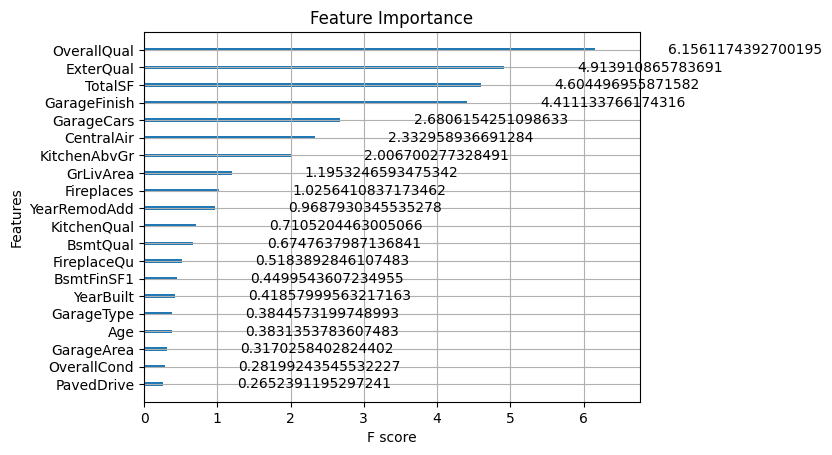

In [117]:
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain', title="Feature Importance")
plt.show()

It is interesting to see that with this fine tunning not only our results got better but our model is better at weighting the features, taking into consideration more features than before.

### Fine, let's get to what matters: Predicting the test.csv

In [118]:
# Convert datasets to DMatrix
d_test = xgb.DMatrix(df_test)

# Predict log-transformed SalePrice
y_test_pred_log = xgb_model.predict(d_test)

In [120]:
# Convert back to original scale
y_test_pred = np.exp(y_test_pred_log)

# Create a DataFrame with the predictions
df_submission = pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': y_test_pred})
df_submission.to_csv('submission.csv', index=False)
print("Submission file was created")

Submission file was created
